In [2]:
import Pkg
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("SpecialFunctions")
Pkg.add("QuadGK")
using Random, Distributions, StatsPlots, SpecialFunctions, QuadGK

In [3]:
## Point Process

function counter(time::Number, events::Array{<:Number})
    n = 0
    if minimum(events) >= time
        return 0
    else
        for k = 1:length(events)
            if events[k] < time
                n += 1
            end
        end
        return n
    end
end

counter (generic function with 1 method)

In [4]:
## Hawkes Intensity

function compensator(time::Number, events::Array{<:Number}, mu::Number, kern::Function)
    if minimum(events) >= time
        return mu
    else
        return mu + sum(kern, time .- events[events .< time])
    end
end

compensator (generic function with 1 method)

In [5]:
## For integrating

function riemannSum(time::Number, f::Function, delta::Number)
    i = 1
    sum = 0
    while i*delta <= time
        sum = sum + delta*f(delta*(i-1))
        i += 1
    end
    if i*delta <= 1
        sum = sum + (time-delta*(i-1))*f(delta*(i-1))
    end
    return sum
end

riemannSum (generic function with 1 method)

In [6]:
function genEvents(alpha::Number, mu::Number, an::Number, sigma::Number)

## Initializing constants/scaling factors and preparing arrays for population
    
    chi = 1/alpha
    
    numImmigrants = 0
    while numImmigrants == 0
        numImmigrants = rand(Poisson(mu))
    end
    events = Float64[]

## Forming the first generation of Immigrants

    for i in 1:numImmigrants              
        U = rand(Uniform())
        push!(events,U)
    end

## Creating a cycle for future generations to have children

    currentGen = events
    nextGen = Float64[]

    while length(currentGen) > 0                                    
        for j in 1:length(currentGen)                               
             numNextGen = rand(Poisson(an))                          
            if numNextGen != 0                                      
                for k in 1:numNextGen                               
                    pos = rand(GeneralizedPareto(0,sigma,chi))        
                    child = currentGen[j]+pos                       
                    if child < 1
                        push!(nextGen,child)
                        push!(events,child)
                    end
                end
            end
        end
        currentGen = nextGen
        nextGen = Float64[]
    end

    events = sort(events)
    return events
end

genEvents (generic function with 1 method)

In [55]:
n=1000
genEvents(2,n,1-1/(n),1/n)

227302-element Vector{Float64}:
 0.0017085190122054783
 0.0029139290241517735
 0.004717250283302388
 0.005096318485869634
 0.005189065849992665
 0.0055340082774984175
 0.005545473248224701
 0.006428169718780685
 0.0066831591455371875
 0.006739339493155301
 0.0067561102078161905
 0.0069788749016540495
 0.007544633072807505
 ⋮
 0.9999683424950693
 0.9999696430456366
 0.999970011860571
 0.9999702680401295
 0.9999737714306488
 0.9999765218213374
 0.9999802468678063
 0.9999827639122187
 0.999984326101203
 0.9999855615734318
 0.9999925585070925
 0.9999969965974226

In [7]:
function plotHawkes(alpha::Number, mu::Number, an::Number, sigma::Number, n::Number, dt::Number)
    
    chi = 1/alpha
    events = genEvents(alpha,mu,an,sigma)

## Functions for model    
    
    kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
    pointProcess(x) = counter(x,events)
    intensity(x) = compensator(x,events,mu,kernel)
    integratedIntensity(x) = riemannSum(x,intensity,dt)
    martingale(x) = pointProcess(x) - integratedIntensity(x)
    
    p1 = plot(kernel,0,1)
    p2 = plot(pointProcess,0,1)
    p3 = plot(intensity,0,1)
    p4 = plot(martingale,0,1)
    
    plot(p1,p2,p3,p4, layout = (2,2))
end

plotHawkes (generic function with 1 method)

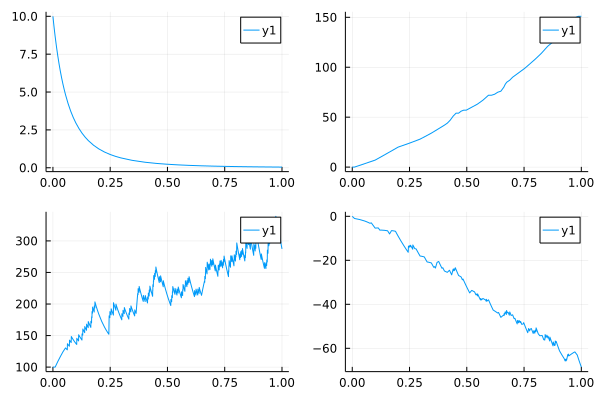

In [75]:
n = 10
alpha = 2
mun = 10*n
an = 1-1/(1000*n)
dt = 1/500
sigma = 10/n
plotHawkes(alpha,mun,an,sigma,n,dt)

In [ ]:
function discretize(martingale::Function, intensity::Function, n::Number, dt::Number)
    
    M = convert(Int,floor(1/dt))
    martVec = zeros(M+1)
    lamVec = zeros(M+1)
    diffVec = zeros(M)
    N = 0
    
## Discretizing the functions    
    
    while N <= M
        martVec[N+1] = martingale(N*dt)
        lamVec[N+1] = intensity(N*dt) 
        if N >= 1
            diffVec[N] = martVec[N+1] - martVec[N]
        end
        N += 1
    end
## Making the Brownian Motion
    
    newlamVec = view(lamVec,1:M)
    partSum = zeros(M)
    partSum = (1/sqrt(n)).*diffVec./sqrt.(newlamVec)
    cumSum = accumulate(+,partSum)
    BMVec = pushfirst!(cumSum,0)
    
## For the QV
    
    integrand = (1/n).*diffVec./newlamVec
    integral = accumulate(+,integrand)
    quadError = integral[M]
    
    return BMVec, lamVec, diffVec, martVec, quadError
end

In [ ]:
## Testing the Variance of B
@time begin
    
m = 100       # Number of samples
n = 1        # Scaling factor
alpha = 2
mun = 10*n
an = 1-1/(1000*n)
dt = 1/500
sigma = 200
chi = 1/alpha
M = convert(Int,floor(1/dt))
data = zeros(m)
data2 = zeros(m)

for k in 1:m
    events = genEvents(alpha,mun,an,sigma)

    kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
    pointProcess(x) = counter(x,events)
    intensity(x) = compensator(x,events,mun,kernel)
    integratedIntensity(x) = riemannSum(x,intensity,dt)
    martingale(x) = pointProcess(x) - integratedIntensity(x)
    
    Vec = discretize(martingale,intensity,n,dt)[1]
    data[k] = (Vec[M+1])^2
    data2[k] = Vec[M+1]
end
    var = mean(data)-mean(data2)^2
end
return var

In [ ]:
function testRescaled(alpha::Number, mu::Number, an::Number, sigma::Number, n::Number, dt::Number, lamVec::Array{<:Number}, diffVec::Array{<:Number})
    
    M = convert(Int,floor(1/dt))
    lCon = n*(1-an)
    mCon = sigma*alpha/(alpha-1)
    intC = (1-an).*lamVec
    N = Array(1:1:M)
    
    f = mu .* (1 .- exp.(-(N .* dt) .* (lCon/mCon)))
    f = pushfirst!(f,0)
    integrand1 = (mu .- intC) .* (lCon/mCon)
    integrand2 = (sqrt(lCon)/mCon) .* sqrt.(intC)
    
    partSum1 = view(integrand1,1:M) .* dt
    partSum2 = view(integrand2,1:M) .* diffVec
    newCumSum = accumulate(+,partSum1+partSum2)

## Right hand side p608    
    
    RHS = pushfirst!(newCumSum,0)
    
    difference = intC .- RHS
    difference2 = intC .- f
    x = 0:dt:1
    y = difference
    z = difference2
    return plot(x,y),plot(x,z),maximum(abs.(difference))
end

In [ ]:
## Testing the equation of rescaled intensity

n = 20
alpha = 2
mun = 10*n
an = 1-1/(1000*n)
dt = 1/500
sigma = 200
chi = 1/alpha

events = genEvents(alpha,mun,an,sigma)

kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
pointProcess(x) = counter(x,events)
intensity(x) = compensator(x,events,mun,kernel)
integratedIntensity(x) = riemannSum(x,intensity,dt)
martingale(x) = pointProcess(x) - integratedIntensity(x)

lamVec = discretize(martingale, intensity, n, dt)[2]
diffVec = discretize(martingale, intensity, n, dt)[3]

p = testRescaled(alpha,mun,an,sigma,n,dt,lamVec,diffVec)[1]
Plots.display(p)
testRescaled(alpha,mun,an,sigma,n,dt,lamVec,diffVec)[3]

In [ ]:
## Side Project

function sample(alpha::Number, sigma::Number)

    chi=1/alpha
    U = rand(Uniform())
    return sigma*alpha*((1-U)^(-chi)-1)
end

In [ ]:
## Side Project

n = 500
N = 1500
alpha = 2
sigma = 2000
an = 1-1/(1000*n)
lCon = n*(1-an)
mCon = sigma*alpha/(alpha-1)
data = zeros(N)
data2 = zeros(N)

for j in 1:N
    geom = rand(Geometric(1-an))
    geom2 = rand(Geometric(lCon/mCon))
    sum1 = 0
    if geom != 0
        for i in 1:geom
            sum1 = sum1 + sample(alpha,sigma)
        end
    end
    data[j] = sum1/n
    data2[j] = geom2
end

plot(histogram(data),histogram(data2))
